In [1]:
import pandas as pd

In [2]:
# read D:\Public_repository\lifesnaps\data\csv_rais_anonymized\daily_fitbit_sema_df_unprocessed.csv
df_daily = pd.read_csv(r'D:\Public_repository\lifesnaps\data\csv_rais_anonymized\daily_fitbit_sema_df_unprocessed.csv')

In [3]:
# read D:\Public_repository\lifesnaps\data\csv_rais_anonymized\hourly_fitbit_sema_df_unprocessed.csv
df_hourly = pd.read_csv(r'D:\Public_repository\lifesnaps\data\csv_rais_anonymized\hourly_fitbit_sema_df_unprocessed.csv')

C:\Users\11097\AppData\Local\Temp\ipykernel_36724\2652128457.py:2: DtypeWarning: Columns (5,10,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hourly = pd.read_csv(r'D:\Public_repository\lifesnaps\data\csv_rais_anonymized\hourly_fitbit_sema_df_unprocessed.csv')


In [4]:
features_daily = df_daily.columns.tolist()

In [5]:
# print column names of df_daily
print(df_daily.columns)

Index(['Unnamed: 0', 'id', 'date', 'nightly_temperature', 'nremhr', 'rmssd',
       'spo2', 'full_sleep_breathing_rate', 'stress_score',
       'sleep_points_percentage', 'exertion_points_percentage',
       'responsiveness_points_percentage', 'daily_temperature_variation',
       'badgeType', 'calories', 'filteredDemographicVO2Max', 'distance',
       'activityType', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
       'mindfulness_session', 'scl_avg', 'resting_hr', 'sleep_duration',
       'minutesToFallAsleep', 'minutesAsleep', 'minutesAwake',
       'minutesAfterWakeup', 'sleep_efficiency', 'sleep_deep_ratio',
       'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'step_goal', 'min_goal', 'max_goal', 'step_goal_label',
       'ALERT',

In [6]:
# print column names of df_hourdly
print(df_hourly.columns)

Index(['Unnamed: 0', 'id', 'date', 'hour', 'temperature', 'badgeType',
       'calories', 'distance', 'activityType', 'bpm', 'mindfulness_session',
       'scl_avg', 'steps', 'minutes_in_default_zone_1',
       'minutes_below_default_zone_1', 'minutes_in_default_zone_2',
       'minutes_in_default_zone_3', 'age', 'gender', 'bmi', 'step_goal',
       'min_goal', 'max_goal', 'step_goal_label', 'ALERT', 'HAPPY', 'NEUTRAL',
       'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS', 'TIRED', 'ENTERTAINMENT',
       'GYM', 'HOME', 'HOME_OFFICE', 'OTHER', 'OUTDOORS', 'TRANSIT',
       'WORK/SCHOOL'],
      dtype='object')


In [7]:
# print all unique ids in df_daily
unique_ids_daily = df_daily['id'].nunique()
print(f'Number of unique ids in df_daily: {unique_ids_daily}')

Number of unique ids in df_daily: 71


In [8]:
# print all unique ids in df_hourly
unique_ids_hourly = df_hourly['id'].nunique()
print(f'Number of unique ids in df_hourly: {unique_ids_hourly}')

Number of unique ids in df_hourly: 71


In [9]:
# how many rows did each patients (ids) have in df_daily?
rows_per_id_daily = df_daily['id'].value_counts()
print(rows_per_id_daily)

id
621e346f67b776a24081744f    244
621e301e67b776a240608a72    244
621e367e67b776a24087d75d    244
621e2f1b67b776a240b3d87c    236
621e342e67b776a2404ce460    223
                           ... 
621e34f767b776a240de4e1a     66
621e339967b776a240e502de     66
621e2fce67b776a240279baa     64
621e32af67b776a24045b4cf     64
621e301367b776a24057738e     64
Name: count, Length: 71, dtype: int64


In [10]:
# random select 80% of the unique ids in df_daily and print them
unique_ids_daily_list = df_daily['id'].unique()
sampled_ids_daily = pd.Series(unique_ids_daily_list).sample(frac=0.8, random_state=42).tolist()
print(f'Randomly selected 80% of unique ids in df_daily: {sampled_ids_daily}')

Randomly selected 80% of unique ids in df_daily: ['621e30e467b776a240e817c7', '621e2e8e67b776a24055b564', '621e341067b776a24037b105', '621e2efa67b776a2409dd1c3', '621e34db67b776a240c9c2be', '621e309b67b776a240b532b0', '621e2f9167b776a240011ccb', '621e329067b776a2402ffad2', '621e33cf67b776a240087de9', '621e2fce67b776a240279baa', '621e326767b776a24012e179', '621e2f7a67b776a240f14425', '621e360b67b776a24039709f', '621e2f1b67b776a240b3d87c', '621e346f67b776a24081744f', '621e324e67b776a2400191cb', '621e351a67b776a240f6204b', '621e32d067b776a2405b7d54', '621e34ff67b776a240e446d6', '621e335a67b776a240bb12ff', '621e301e67b776a240608a72', '621e32af67b776a24045b4cf', '621e339967b776a240e502de', '621e322367b776a240e44e9b', '621e2f5767b776a240d8f9d6', '621e34ca67b776a240be3b69', '621e342e67b776a2404ce460', '621e33b067b776a240f39e56', '621e33ed67b776a2401cf5f7', '621e30b267b776a240c5e13f', '621e34f767b776a240de4e1a', '621e333567b776a240a0c217', '621e312a67b776a240164d59', '621e332267b776a24092a584'

In [11]:
# make 80% as train set and 20% as test set based on the randomly selected unique ids in df_daily
train_df_daily = df_daily[df_daily['id'].isin(sampled_ids_daily)]
test_df_daily = df_daily[~df_daily['id'].isin(sampled_ids_daily)]

In [12]:
# percentage of 0 in the column 'sleep_points_percentage'
sleep_points_percentage_0_percentage = (train_df_daily['sleep_points_percentage'] == 0).mean() * 100
print(f'Percentage of 0 in the column "sleep_points_percentage": {sleep_points_percentage_0_percentage:.2f}%')

Percentage of 0 in the column "sleep_points_percentage": 4.11%


In [13]:
# how many 0 are there in the column 'sleep_points_percentage' in train_df_daily?
sleep_points_percentage_0_count = (train_df_daily['sleep_points_percentage'] == 0).sum()
print(f'Number of 0 in the column "sleep_points_percentage" in train_df_daily: {sleep_points_percentage_0_count}')

Number of 0 in the column "sleep_points_percentage" in train_df_daily: 250


In [14]:
# how many nan are there in train_df_daily?
nan_count_train_df_daily = train_df_daily.isna().sum().sum()
print(f'Number of nan in train_df_daily: {nan_count_train_df_daily}')

Number of nan in train_df_daily: 197508


In [15]:
# percentage of nan in train_df_daily
total_cells_train_df_daily = train_df_daily.size
nan_percentage_train_df_daily = (nan_count_train_df_daily / total_cells_train_df_daily) * 100
print(f'Percentage of nan in train_df_daily: {nan_percentage_train_df_daily:.2f}%')

Percentage of nan in train_df_daily: 51.50%


# Feature Selection

In [16]:
# 1. 定义破解所需的 Feature 列表
crack_features = [
    # === 目标变量 (Y) ===
    'sleep_points_percentage',
    
    # === 嫌疑组 A: 时长维度 (Duration) ===
    # 核心逻辑：睡了多久？
    'minutesAsleep',          # 最核心指标
    'sleep_duration',         # 总卧床时间 (含醒着)
    'minutesToFallAsleep',    # 入睡潜伏期
    'minutesAfterWakeup',     # 赖床时间
    
    # === 嫌疑组 B: 质量维度 (Quality / Stages) ===
    # 核心逻辑：睡得沉吗？比例如何？
    'sleep_efficiency',       # 效率
    'sleep_deep_ratio',       # 深睡占比 (加分项)
    'sleep_rem_ratio',        # 快速眼动占比 (加分项)
    'sleep_light_ratio',      # 浅睡占比
    'sleep_wake_ratio',       # 清醒占比 (扣分项)
    'minutesAwake',           # 醒来的绝对分钟数 (扣分项)
    
    # === 嫌疑组 C: 恢复维度 (Restoration) ===
    # 核心逻辑：身体充电了吗？(最难算的部分)
    'resting_hr',             # 静息心率 (基准线)
    'nremhr',                 # 非快速眼动心率 (睡眠心率)
                              # *提示：Fitbit通常计算 (nremhr < resting_hr) 的程度
    'rmssd',                  # 心率变异性 (衡量神经系统恢复)
    'nightly_temperature',    # 夜间体温偏差 (可能影响恢复分)
    'full_sleep_breathing_rate', # 呼吸率
    # 'spo2',                   # 血氧 (较新的指标，可能权重较低)
    
    # === 嫌疑组 D: 控制变量 (Control) ===
    # 算法可能会根据年龄调整“正常标准” (例如老人的深睡本身就少)
    'age',
    'gender',
    'bmi',
    'id'
]

# 2. 创建干净的子集
# 过滤掉列表中没有的列，只保留相关列
df_crack = df_daily[crack_features].copy()

# 3. (关键步骤) 特征工程 - 构造交互项
# Fitbit 的恢复分数通常是看 "睡眠心率" 比 "静息心率" 低多少
# 所以我们要手动造一个 Feature 给模型
df_crack['hr_dip'] = df_crack['resting_hr'] - df_crack['nremhr']

# 检查一下
print(f"Selected {len(df_crack.columns)} features for reverse engineering.")
print(df_crack.head())

Selected 21 features for reverse engineering.
   sleep_points_percentage  minutesAsleep  sleep_duration  \
0                 0.833333          445.0      31260000.0   
1                 0.833333          460.0      32880000.0   
2                 0.966667          493.0      33600000.0   
3                 0.933333          540.0      37620000.0   
4                 0.866667          493.0      33660000.0   

   minutesToFallAsleep  minutesAfterWakeup  sleep_efficiency  \
0                  0.0                 0.0              93.0   
1                  0.0                 0.0              94.0   
2                  0.0                 0.0              96.0   
3                  0.0                 0.0              93.0   
4                  0.0                 0.0              94.0   

   sleep_deep_ratio  sleep_rem_ratio  sleep_light_ratio  sleep_wake_ratio  \
0          1.243243         1.341772           0.921642          0.987013   
1          1.466667         1.197531           0

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [18]:
# ==========================================
# 2. 数据预处理 & 清洗 (Preprocessing)
# ==========================================

# A. 转化为百分制 (0-1 -> 0-100)
df_crack['sleep_points_percentage'] = df_crack['sleep_points_percentage'] * 100

In [19]:
# B. 清洗 Target (Label)
# 去除 NaN
df_crack = df_crack.dropna(subset=['sleep_points_percentage'])

In [20]:
# 去除 0.0 (系统错误值)
df_crack = df_crack[df_crack['sleep_points_percentage'] > 0.1]

only 1580 rows (1580 nights) (22 nights per person)

In [21]:
# how many rows did each patients (ids) have in df_daily?
rows_per_id_daily = df_crack['id'].value_counts()
print(rows_per_id_daily)

id
621e2f9167b776a240011ccb    86
621e32e667b776a2406d2f1c    83
621e337667b776a240ce78ab    80
621e2eaf67b776a2406b14ac    77
621e2f1b67b776a240b3d87c    74
621e326767b776a24012e179    67
621e33b067b776a240f39e56    66
621e2e8e67b776a24055b564    63
621e33cf67b776a240087de9    63
621e2fce67b776a240279baa    63
621e375b67b776a240290cdc    61
621e366567b776a24076a727    59
621e323667b776a240f19134    58
621e333967b776a240a3cd06    58
621e32af67b776a24045b4cf    57
621e329067b776a2402ffad2    56
621e339967b776a240e502de    54
621e360b67b776a24039709f    43
621e346f67b776a24081744f    42
621e30b267b776a240c5e13f    39
621e36f967b776a240e5e7c9    39
621e2f3967b776a240c654db    39
621e362467b776a2404ad513    37
621e36c267b776a240ba2756    34
621e2f6167b776a240e082a9    34
621e301e67b776a240608a72    29
621e34ca67b776a240be3b69    27
621e351a67b776a240f6204b    21
621e342e67b776a2404ce460    20
621e2f5767b776a240d8f9d6    16
621e32d967b776a240627414     9
621e30e467b776a240e817c7     6
621e3

In [22]:
# C. 构造关键特征 (Feature Engineering)
# 假设：恢复分 = 静息心率 - 睡眠心率 (心率下降越多越好)
if 'resting_hr' in df_crack.columns and 'nremhr' in df_crack.columns:
    df_crack['hr_dip'] = df_crack['resting_hr'] - df_crack['nremhr']


In [23]:
# reset index of df_crack
df_crack = df_crack.reset_index(drop=True)

In [24]:
# percentage of nan in each column in df_crack
nan_percentage_per_column = df_crack.isna().mean() * 100

In [25]:
# D. 清洗 Features (X)
# 为了保证逆向工程的数学精确性，我们删除任何包含空值的行 (Strict Drop)
print(f"清洗前样本数: {len(df_crack)}")
df_crack = df_crack.dropna()
print(f"清洗后用于训练的样本数: {len(df_crack)}")

清洗前样本数: 1580
清洗后用于训练的样本数: 1373


In [26]:
df_crack_copy = df_crack.copy()

In [27]:
df_crack = df_crack_copy

In [28]:
# 假设 df_crack 是你现在的 DataFrame

# 2. 处理 Gender (0=Male, 1=Female)
# 使用 map 是一种快速替换的方法
df_crack['gender'] = df_crack['gender'].map({'MALE': 0, 'FEMALE': 1})

# 3. 处理 Age (<30=0, >30=1)
df_crack['age'] = df_crack['age'].map({'<30': 0, '>=30': 1})

# 4. 处理 BMI (清洗特殊符号)
def clean_bmi(val):
    if isinstance(val, str):
        if '<' in val:
            return 18.0  # 估算值
        elif '>' in val:
            return 28.0  # 估算值
    return float(val)

# 应用清洗函数
df_crack['bmi'] = df_crack['bmi'].apply(clean_bmi)

In [29]:
# --- 最终检查 ---
print("数据类型检查 (必须全部是 int 或 float):")
print(df_crack.dtypes)

数据类型检查 (必须全部是 int 或 float):
sleep_points_percentage      float64
minutesAsleep                float64
sleep_duration               float64
minutesToFallAsleep          float64
minutesAfterWakeup           float64
sleep_efficiency             float64
sleep_deep_ratio             float64
sleep_rem_ratio              float64
sleep_light_ratio            float64
sleep_wake_ratio             float64
minutesAwake                 float64
resting_hr                   float64
nremhr                       float64
rmssd                        float64
nightly_temperature          float64
full_sleep_breathing_rate    float64
age                            int64
gender                         int64
bmi                          float64
id                            object
hr_dip                       float64
dtype: object


# Split

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [31]:
# ==========================================
# 0. 准备工作：确保 'id' 还在 df_crack 里
# ==========================================
# (如果你之前的代码把它drop了，请重新生成一下 df_crack，保留 'id' 列)

# ==========================================
# 1. 获取所有唯一的 ID (Unique Users)
# ==========================================
unique_ids = df_crack['id'].unique()
print(f"总共有 {len(unique_ids)} 位独立用户。")

# ==========================================
# 2. 切分 ID (Split IDs)
# ==========================================
# 这里我们是对“人”进行切分，而不是对“行”进行切分
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

print(f"训练集包含用户数: {len(train_ids)}")
print(f"测试集包含用户数: {len(test_ids)}")

# ==========================================
# 3. 根据 ID 筛选数据行 (Filter Rows)
# ==========================================
# 只有 ID 在 train_ids 里的行才进入训练集
df_train = df_crack[df_crack['id'].isin(train_ids)].copy()
# 只有 ID 在 test_ids 里的行才进入测试集
df_test = df_crack[df_crack['id'].isin(test_ids)].copy()

print(f"训练集数据量 (行数): {len(df_train)}")
print(f"测试集数据量 (行数): {len(df_test)}")

# ==========================================
# 4. 最后的清理：扔掉 ID 列
# ==========================================
# 模型训练时绝对不能有 ID，否则会报错或过拟合
# 我们只保留数值型特征 (X) 和 目标变量 (y)

# 定义要扔掉的非特征列
drop_cols = ['id', 'sleep_points_percentage']

# 构建 X_train, y_train
X_train = df_train.drop(columns=drop_cols)
y_train = df_train['sleep_points_percentage']

# 构建 X_test, y_test
X_test = df_test.drop(columns=drop_cols)
y_test = df_test['sleep_points_percentage']

# ==========================================
# 5. 检查最终输入矩阵
# ==========================================
print("\n最终输入模型的特征列表:")
print(X_train.columns.tolist())

# 现在你可以把 X_train, y_train 喂给线性回归或随机森林了

总共有 31 位独立用户。
训练集包含用户数: 24
测试集包含用户数: 7
训练集数据量 (行数): 1073
测试集数据量 (行数): 300

最终输入模型的特征列表:
['minutesAsleep', 'sleep_duration', 'minutesToFallAsleep', 'minutesAfterWakeup', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_rem_ratio', 'sleep_light_ratio', 'sleep_wake_ratio', 'minutesAwake', 'resting_hr', 'nremhr', 'rmssd', 'nightly_temperature', 'full_sleep_breathing_rate', 'age', 'gender', 'bmi', 'hr_dip']


# Train - Test

In [32]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
import pandas as pd

In [44]:
# ==========================================
# 🌲 模型 2: 随机森林 (Random Forest) - 修正版
# ==========================================
# 训练模型
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
# 改进版随机森林
rf = RandomForestRegressor(
    n_estimators=200,       # 树多一点，通常更稳定
    max_depth=10,           # 【核心1】限制树高：不准长太深，防死记硬背
    min_samples_leaf=5,     # 【核心2】叶子节点最少样本数：如果不满5个样本，就不准形成规则
    max_features='sqrt',    # 【核心3】强制每棵树只能看一部分特征：防止某个特征独大
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                      n_estimators=200, n_jobs=-1, random_state=42)

In [48]:
from sklearn.model_selection import GridSearchCV

# 1. 定义我们要尝试的参数组合
param_grid = {
    'n_estimators': [100, 200, 300, 1000],
    'max_depth': [3, 5, 10, 15, 20, None],        # 试试浅树和深树
    'min_samples_split': [2, 5, 10, 20],       # 分裂门槛
    'min_samples_leaf': [1, 2, 4, 8, 16],      # 叶子节点门槛 (越大越防过拟合)
    'max_features': ['sqrt', None]         # 试试看所有特征 vs 部分特征
}

# 2. 建立搜索器
# cv=5 意味着做 5 折交叉验证，比单纯看 test set 更准
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1,
    verbose=2,
    scoring='r2'
)

# 3. 开始训练 (这步会比较慢，可能要跑几分钟)
print("正在寻找最佳参数...")
grid_search.fit(X_train, y_train)

# 4. 输出结果
print(f"最佳参数组合: {grid_search.best_params_}")
print(f"最佳验证集 R2: {grid_search.best_score_:.4f}")

# 5. 直接拿最佳模型去预测
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
print(f"优化后的 Test R2: {r2_score(y_test, y_pred_tuned):.4f}")

正在寻找最佳参数...
Fitting 5 folds for each of 960 candidates, totalling 4800 fits


d:\Public\20220221_Anaconda_Install\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


最佳参数组合: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
最佳验证集 R2: 0.5249
优化后的 Test R2: 0.4629


In [47]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 预测
# y_pred_train = rf.predict(X_train)
# y_pred_test = rf.predict(X_test)
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# 2. 计算指标函数
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"📊 {name} Set Performance:")
    print(f"   RMSE: {rmse:.4f} (越低越好)")
    print(f"   MAE:  {mae:.4f} (平均误差分)")
    print(f"   R^2:  {r2:.4f} (越接近1越好)")
    print("-" * 30)

# 3. 打印对比
print("\n" + "="*40)
print("⚖️ 训练集 vs 测试集 表现对比")
print("="*40)

evaluate_model(y_train, y_pred_train, "Train")
evaluate_model(y_test, y_pred_test, "Test")


⚖️ 训练集 vs 测试集 表现对比
📊 Train Set Performance:
   RMSE: 2.7108 (越低越好)
   MAE:  2.1661 (平均误差分)
   R^2:  0.9461 (越接近1越好)
------------------------------
📊 Test Set Performance:
   RMSE: 8.6006 (越低越好)
   MAE:  7.0993 (平均误差分)
   R^2:  0.4603 (越接近1越好)
------------------------------


# Reverse Engineer

# Feature Importance

In [35]:
import shap
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

## rf

In [36]:
# 计算 R2
y_pred_rf = rf.predict(X_test)
print(f"Random Forest Test R^2: {r2_score(y_test, y_pred_rf):.4f}")

# 显示前 10 个最重要的特征
# 🛠️ 修正点：这里把 X.columns 改成了 X_train.columns
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔥 Top 10 影响睡眠分数的因素:")
print(feature_importances.head(10))

Random Forest Test R^2: 0.4416

🔥 Top 10 影响睡眠分数的因素:
                      feature  importance
6             sleep_rem_ratio    0.412470
4            sleep_efficiency    0.133815
0               minutesAsleep    0.082889
5            sleep_deep_ratio    0.055727
8            sleep_wake_ratio    0.046780
9                minutesAwake    0.038532
10                 resting_hr    0.035997
7           sleep_light_ratio    0.030884
14  full_sleep_breathing_rate    0.027368
18                     hr_dip    0.025905


In [37]:
# 确保使用训练好的随机森林模型 rf
# ==========================================
# 1. 排列重要性 (Permutation Importance)
# ==========================================
print("正在计算排列重要性 (这可能需要几秒钟)...")
result = permutation_importance(
    rf, X_test, y_test, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# 整理结果
perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print("\n🏆 排列重要性排名 (Top 10):")
# 这里的 Importance 意味着：打乱这个特征，R2 会下降多少
print(perm_df.head(10))

正在计算排列重要性 (这可能需要几秒钟)...

🏆 排列重要性排名 (Top 10):
                Feature  Importance_Mean  Importance_Std
6       sleep_rem_ratio         0.353370        0.031809
4      sleep_efficiency         0.199689        0.030981
0         minutesAsleep         0.113402        0.023739
5      sleep_deep_ratio         0.045098        0.014292
9          minutesAwake         0.039158        0.009246
8      sleep_wake_ratio         0.031348        0.011739
7     sleep_light_ratio         0.022875        0.008262
13  nightly_temperature         0.005979        0.002548
3    minutesAfterWakeup         0.001823        0.001759
16               gender         0.000734        0.000962


## shap


正在计算 SHAP 值 (揭示正负影响)...


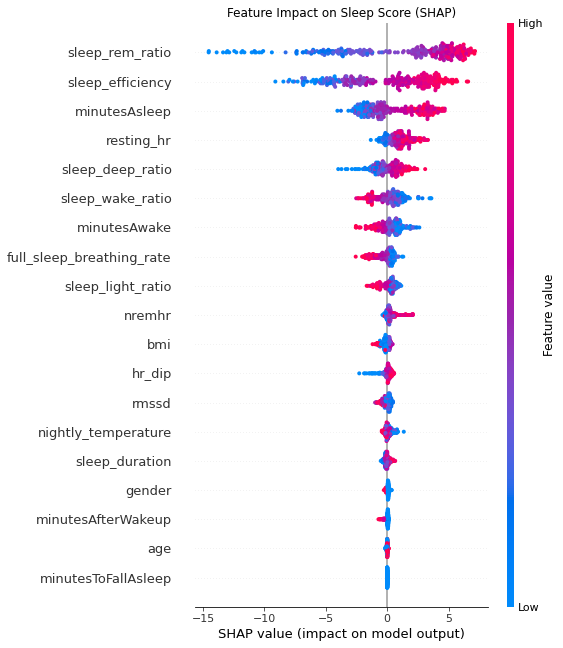

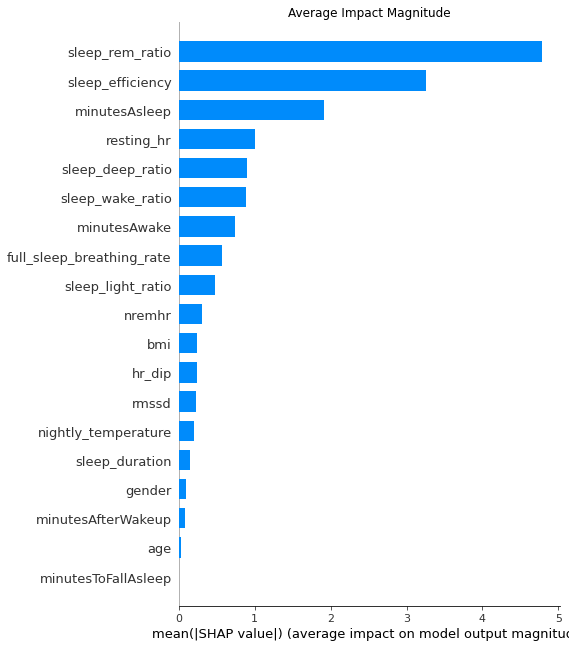

In [38]:
# ==========================================
# 2. SHAP 值分析 (最直观的可视化)
# ==========================================
print("\n正在计算 SHAP 值 (揭示正负影响)...")

# 创建解释器
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# 1. 总结图 (Beeswarm Plot)
# 这张图最厉害：
# - 颜色代表特征数值大小 (红高蓝低)
# - X轴代表对分数的影响 (右边是加分，左边是减分)
plt.figure(figsize=(10, 8))
plt.title("Feature Impact on Sleep Score (SHAP)")
shap.summary_plot(shap_values, X_test, show=False)
plt.show()

# 2. 柱状图 (平均绝对影响)
plt.figure(figsize=(10, 8))
plt.title("Average Impact Magnitude")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.show()

## ols

In [39]:
# OLS

print("\n" + "="*40)
print("🤖 模型 1: 线性回归 (OLS) - 查看具体权重")
print("="*40)
# 加上截距项 (Constant)，即基础分
X_train_ols = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_ols).fit()
print(ols_model.summary())


🤖 模型 1: 线性回归 (OLS) - 查看具体权重
                               OLS Regression Results                              
Dep. Variable:     sleep_points_percentage   R-squared:                       0.661
Model:                                 OLS   Adj. R-squared:                  0.656
Method:                      Least Squares   F-statistic:                     121.2
Date:                     Thu, 12 Feb 2026   Prob (F-statistic):          7.17e-234
Time:                             20:48:55   Log-Likelihood:                -3578.2
No. Observations:                     1073   AIC:                             7192.
Df Residuals:                         1055   BIC:                             7282.
Df Model:                               17                                         
Covariance Type:                 nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

## dt

In [40]:
# ==========================================
# 🌿 模型 3: 决策树 (Decision Tree) - 修正版
# ==========================================
print("\n" + "="*40)
print("🌿 模型 3: 决策树 (Decision Tree) - 查看关键阈值")
print("="*40)

# 限制深度为 3，方便打印出人类可读的规则
dt = DecisionTreeRegressor(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# 🛠️ 修正点：这里也把 X.columns 改成了 X_train.columns
print(export_text(dt, feature_names=list(X_train.columns)))


🌿 模型 3: 决策树 (Decision Tree) - 查看关键阈值
|--- sleep_rem_ratio <= 0.90
|   |--- sleep_rem_ratio <= 0.59
|   |   |--- sleep_wake_ratio <= 0.77
|   |   |   |--- value: [67.21]
|   |   |--- sleep_wake_ratio >  0.77
|   |   |   |--- value: [59.87]
|   |--- sleep_rem_ratio >  0.59
|   |   |--- sleep_efficiency <= 95.50
|   |   |   |--- value: [68.32]
|   |   |--- sleep_efficiency >  95.50
|   |   |   |--- value: [77.72]
|--- sleep_rem_ratio >  0.90
|   |--- sleep_efficiency <= 93.50
|   |   |--- sleep_efficiency <= 90.50
|   |   |   |--- value: [73.25]
|   |   |--- sleep_efficiency >  90.50
|   |   |   |--- value: [79.21]
|   |--- sleep_efficiency >  93.50
|   |   |--- minutesAsleep <= 421.50
|   |   |   |--- value: [81.23]
|   |   |--- minutesAsleep >  421.50
|   |   |   |--- value: [89.20]



# Matrix of Coeff

In [41]:
# 读取 csv 文件。
data = X_train.copy()

# 计算每一列的中位数和标准差
medians = data.median()
stds = data.std()

# # 对大于 1000 的替换为中位数
# for col in data.columns:
#     data.loc[data[col] > 1000, col] = medians[col]

# 计算相关矩阵
corr_matrix = data.corr()

# 根据每一行中绝对值大于 0.7 的元素个数排序，打印前面一百项
sort_order = corr_matrix.abs().gt(0.7).sum(axis=1).sort_values(ascending=False)
for i in sort_order.index[:100]:
    print("Index: ", i, ", Count: ", sort_order[i])

Index:  minutesAwake , Count:  3
Index:  sleep_duration , Count:  3
Index:  sleep_wake_ratio , Count:  2
Index:  nremhr , Count:  2
Index:  resting_hr , Count:  2
Index:  minutesAsleep , Count:  2
Index:  sleep_rem_ratio , Count:  1
Index:  sleep_light_ratio , Count:  1
Index:  sleep_deep_ratio , Count:  1
Index:  sleep_efficiency , Count:  1
Index:  minutesAfterWakeup , Count:  1
Index:  minutesToFallAsleep , Count:  1
Index:  rmssd , Count:  1
Index:  nightly_temperature , Count:  1
Index:  full_sleep_breathing_rate , Count:  1
Index:  age , Count:  1
Index:  gender , Count:  1
Index:  bmi , Count:  1
Index:  hr_dip , Count:  1
